In [1]:
###
# Packages
###
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

###
# Packages Options
###
pd.options.mode.chained_assignment = None

In [2]:
### Inputs
season = '2020-2021'
data_dir = '%s%s%s%s' % (os.getcwd(), '\\Datas\\', season, '\\df_shots_cleaned.csv')

In [3]:
### DL of dataset
df_cleaned = pd.read_csv(data_dir)

### Small last cleaning for graph purposes
dic_shot = {0: 'missed', 1: 'made'}
df_cleaned['result_str'] = df_cleaned['result'].map(dic_shot)

In [4]:
df_cleaned

,result,away_score,home_score,player_team_scorediff,play_length,elapsed,shot_distance,area_shot,player_home,player_away,...,shots_player_made,shots_player_total,FG_player,player_streak,assist_player_total,ratio_assist_player,Position,Experience,Age,result_str
0,1,2,2,-2,16,I_00-02,22,Long_Paint_Shot,1,0,...,0,0,0.00,0,0,0.0,PG,9,28,made
1,1,4,2,0,11,I_00-02,1,Under_the_Circle,0,1,...,0,0,0.00,0,0,0.0,C,0,19,made
2,1,4,5,-2,22,I_00-02,26,3pt_Middle,1,0,...,0,0,0.00,0,0,0.0,PF,12,32,made
3,0,4,5,-1,18,I_00-02,24,3pt_Left_Corner,0,1,...,0,0,0.00,0,0,0.0,PF,6,25,missed
4,1,4,7,1,2,I_00-02,5,Under_the_Circle,1,0,...,1,1,100.00,1,1,100.0,PF,12,32,made
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201520,1,96,102,4,18,I_46-48,17,2pt_Left_Corner,1,0,...,5,12,41.66,1,0,0.0,SF,8,29,made
201521,0,96,102,-6,6,I_46-48,26,3pt_Top_Left,0,1,...,7,19,36.84,1,0,0.0,SG,5,24,missed
201522,0,96,104,-8,7,I_46-48,28,3pt_Long_Shots,0,1,...,10,17,58.80,3,1,10.0,PG,15,35,missed
201523,1,98,104,-8,6,I_46-48,2,Under_the_Circle,0,1,...,10,18,55.56,-1,1,10.0,PG,15,35,made


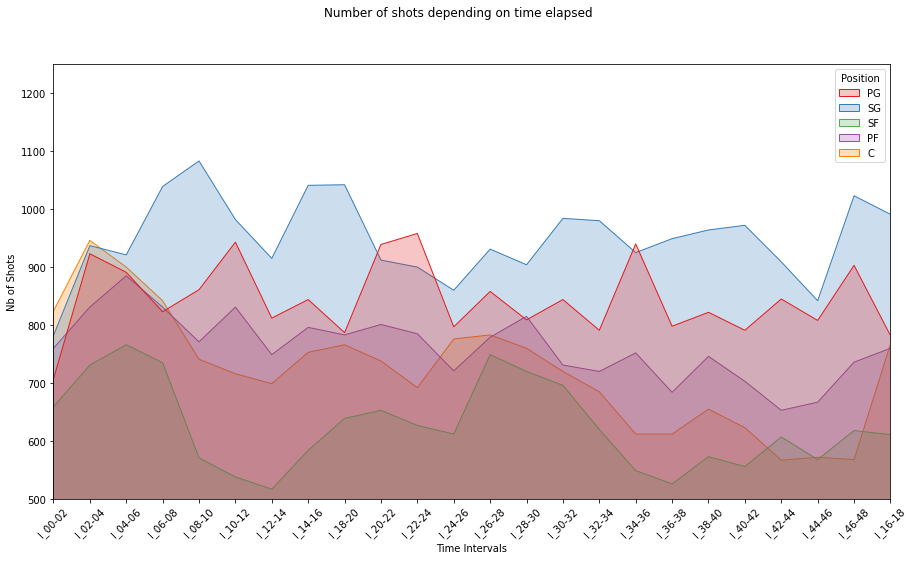

In [41]:
# Who shoots depending on time and pts diff
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Number of shots depending on time elapsed')

positions = ['PG', 'SG', 'SF', 'PF', 'C']
palette = sns.color_palette('Set1', 5)

sns.histplot(
    # x=df_cleaned.elapsed, 
    x=df_cleaned.loc[df_cleaned.result == 1, 'elapsed'],
    hue=df_cleaned.Position, hue_order=positions,  
    element='poly', 
    palette=palette
    )
ax.set_xlabel('Time Intervals')
ax.set_xlim((0, 23))
ax.set_ylabel('Nb of Shots')
ax.set_ylim((500, 1250))
ax.tick_params(axis='x', labelrotation=45)

In [36]:
# Tree map
df_for_tree = df_cleaned.pivot_table(
    values='result', 
    columns='result_str', 
    index=['Position', 'area_shot'], 
    aggfunc='count'
    ).reset_index()

df_for_tree['FG'] = round(
    100 * df_for_tree['made'] / (df_for_tree['missed'] + df_for_tree['made']), 
    2
    )

fig_treemap = px.treemap(data_frame=df_for_tree, 
           path=[px.Constant('All'), 'Position', 'area_shot'], 
           values='made', 
           color='FG', color_continuous_scale='RdBu', 
           width=900, height=600
           )

fig_treemap.data[0].hovertemplate = 'Label: %{label}<br>FG: %{color:.2f}<br>Nb Made: %{value}'
fig_treemap.show()

<Axes: xlabel='player_streak', ylabel='Count'>

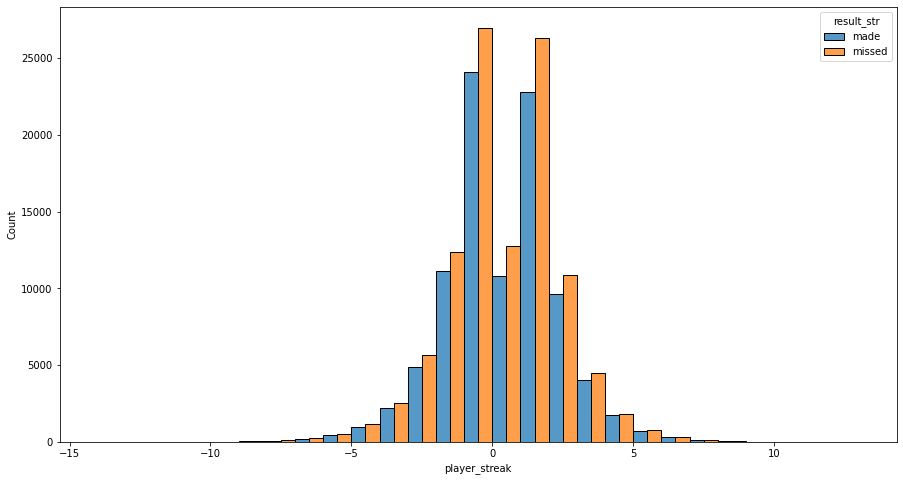

In [56]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.histplot(
    data=df_cleaned,
    x='player_streak', 
    hue='result_str', 
    # stat='percent',
    multiple='dodge', binwidth=1, discrete=False
    )